# Scalar Bilevel ROF Single Gaussian (SG)
We will solve the following bilevel problem

$$
\min_\lambda \|\hat{u}-\bar{u}\|^2 + \beta\lambda^2\\
\text{s.t. } \hat{u} = arg\min_u \frac{1}{2}\|u-f\|^2+\lambda\|\mathbb{K} u\|_{2,1} 
$$

We will use a small dataset of one sample contaminated with gaussian noise to learn the optimal parameter for the ROF image denoising model.

In [1]:
include("../../src/BilevelImagingParameterLearning.jl")
using .BilevelImagingParameterLearning

In [2]:
using Random, Images, TestImages, ImageQualityIndexes, StructuredOptimization, AbstractOperators, Plots
Random.seed!(123);

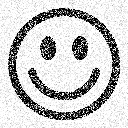

In [3]:
# Noisy image
f = datasetimage("1_smiley_noisy","../../src/datasets/smiley_dataset")
f[f .< 0] .= 0. # Make sure pixels are in range
f[f .> 1] .= 1.
Gray.(f)

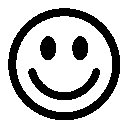

In [4]:
# Ground truth
ut = datasetimage("1_smiley_original","../../src/datasets/smiley_dataset")
ut[ut .< 0] .= 0. # Make sure pixels are in range
ut[ut .> 1] .= 1.
Gray.(ut)

In [5]:
println("SSIM: ",ssim(f,ut))
println("PSNR: ",psnr(f,ut))

SSIM: 0.41487045600825345
PSNR: 13.07757184046984


## Bilevel Cost Function
First, we will plot the cost function to see the form it has for this particular problem

In [95]:
# Lower Level Solver
function lower_level_solver(lambda,Y,V,U)
    @minimize ls(-V'*U+Y) + conj(lambda*norm(U,2,1,2)) with ForwardBackward(tol = 1e-3, gamma = 1/8, fast = true) 
    out = -V'*(~U)+Y
    out[out .< 0] .= 0.
    out[out .> 1] .= 1.
    return out
end

# Upper level cost
function upper_level_cost(ut,u,beta,lambda)
    return 0.5*norm(vcat((u-ut)...))^2 + 0.5*beta*lambda^2
end

upper_level_cost (generic function with 1 method)

In [96]:
K = Variation(size(f)) # Define the finite differences gradient operator
U = Variable(size(K,1)...)
beta = 0.01;

In [97]:
using Distributed

lambda_range = 0.005:0.005:2;

costs = Float64[]
ssim_val = Float64[]
@distributed for lambda in lambda_range
    U_hat = lower_level_solver(lambda,f,K,U)
    push!(costs,upper_level_cost(ut,U_hat,beta,lambda))
    push!(ssim_val,ssim(U_hat,ut))
end

Task (done) @0x000000010c422890

In [98]:
# Saving generated data
using JLD
save("smiley_scalar_rof_cost.jld", "lambda", lambda_range, "costs", costs, "ssim_val",ssim_val)

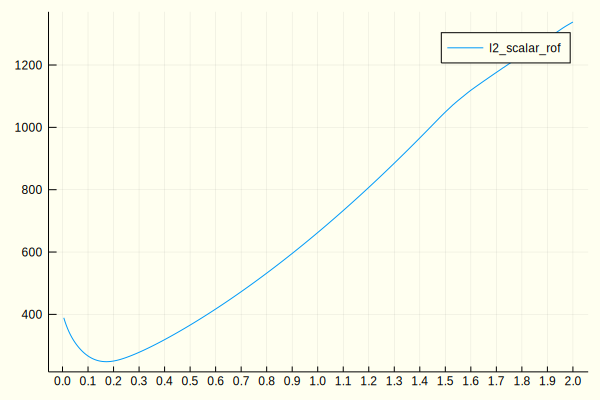

In [99]:
using Plots
d = load("smiley_scalar_rof_cost.jld")
plot(d["lambda"],d["costs"],label="l2_scalar_rof",xticks = 0:0.1:5, background_color = :ivory)

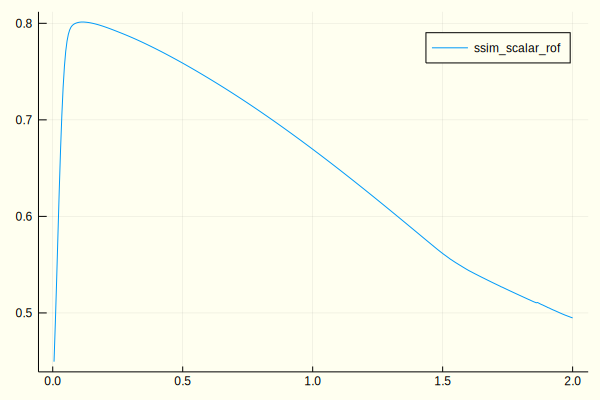

In [100]:
plot(d["lambda"],d["ssim_val"],label="ssim_scalar_rof",xticks = 0:0.5:5, background_color = :ivory)

## Solving Bilevel Problem
We will define a numerical strategy based on an inexact Trust Region method to solve the bilevel problem. First, we need to define a gradient calculation

In [93]:
include("gradient_solver.jl")

gradient_solver (generic function with 2 methods)

In [94]:
nabla = gradient_matrix(size(f))
grads = Float64[]
lambda_range = 0.1:0.1:2;
@distributed for lambda in lambda_range
    u = lower_level_solver(lambda,f,K,U)
    grad = gradient_solver(u,ut,f,lambda,beta,K,nabla)
    push!(grads,grad)
    println("$lambda, $grad")
end

0.1, 373.9000561085846
0.2, 632.3375424459118


Task (runnable) @0x00000001098caf50

0.3, 725.8261483288335
0.4, -2014.6956537789756
0.5, 1348.805468483033
0.6, 1494.9235475745322
0.7, 1538.8414464757248
0.8, 1844.907228507401
0.9, 2002.1157347218316
1.0, 2111.4138564883438
1.1, 2737.9807442118777
1.2, 3500.760725353129
1.3, 2619.576806956252
1.4, 1566.4456546998474
1.5, 257.6273432603729
1.6, 695.5318565630415
1.7, -4529.889935992429
1.8, 603.6781911724719
1.9, 1632.4307650444393
2.0, 594.5304958273657


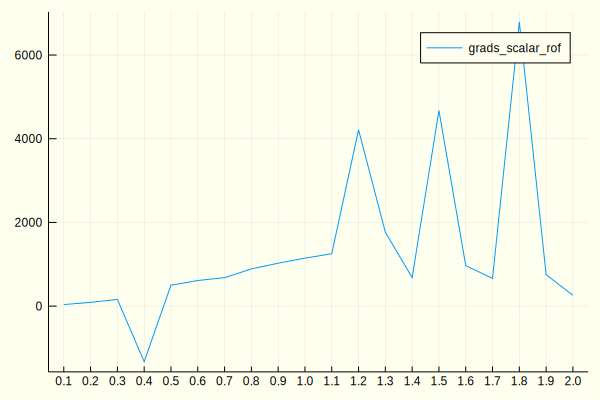

In [92]:
plot(lambda_range,grads,label="grads_scalar_rof",xticks = 0:0.1:2, background_color = :ivory)

In [44]:
@time Adj = gradient_solver(u,ut,lambda,beta,K,nabla)

  1.429760 seconds (630 allocations: 259.213 MiB, 11.36% gc time)


0.21352991390492496

In [70]:
v = rand(10,10)
vt = zeros(10,10)
nabla2 = gradient_matrix(size(v))
K2 = Variation(size(v))
@time grad = gradient_solver(v,vt,0.002,K2,nabla2)

  0.330432 seconds (1.03 M allocations: 49.276 MiB, 5.23% gc time)


52.36070718358338

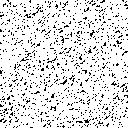

In [24]:
Ku = K*u
norms = sqrt.(sum(Ku.^2, dims=2))
norms = reshape(norms,128,128) # Inactive set
Gray.(norms .> 1e-3)